## Library Imports

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
#import pillow as pil
%matplotlib inline

## Create image pre-processing function

In [2]:
# Function to preprocess the image with Keras
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

## Load the metadata file.  Create a ground truth column.

## Display a random test image

BreaKHis_v1/histology_slides/breast/ductal_carcinoma/SOB_M_DC-14-13412-100-021.png


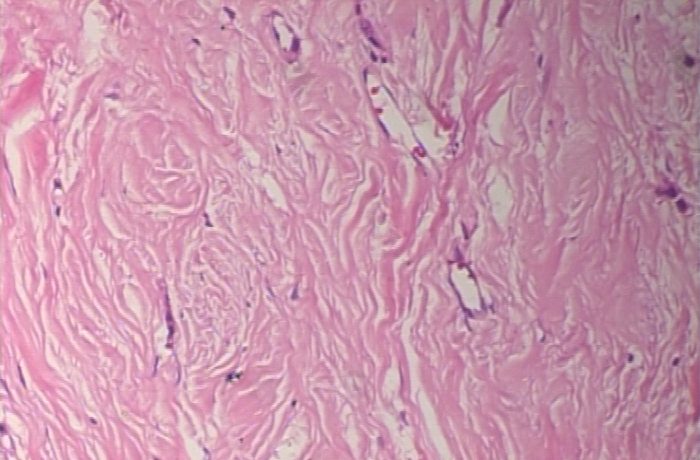

In [3]:
import random
# Display test image
from IPython.display import Image
a = ["adenosis", "ductal_carcinoma", "fibroadenoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma", "phyllodes_tumor", "tubular_carcinoma"]
random_subfolder = 'BreaKHis_v1/histology_slides/breast/'+ random.choice(a) + '/'
image_file = random.choice([x for x in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, x))])
print (random_subfolder+image_file)
Image(filename=random_subfolder+image_file, width=400,height=260)

In [4]:
mobile_v3 = tf.keras.applications.MobileNetV3Large()

## Define the training and validation datasets

In [5]:
path_to_files = 'BreaKHis_v1/histology_slides/breast/'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  labels="inferred",
  validation_split=0.20,
  subset="training",
  seed=42,
  image_size=(224, 224),
  batch_size=12,
  shuffle=True
)
  
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  labels="inferred",
  validation_split=0.20,
  subset="validation",
  seed=42,
  image_size=(224, 224),
  batch_size=12,
  shuffle=True
)
val_batches = tf.data.experimental.cardinality(val_dataset).numpy()
val_dataset = val_dataset.take(0.7*val_batches)
test_dataset = val_dataset.skip(0.3*val_batches)

#print(val_batches)
print(tf.data.experimental.cardinality(test_dataset).numpy())

Found 7909 files belonging to 8 classes.
Using 6328 files for training.
Found 7909 files belonging to 8 classes.
Using 1581 files for validation.
53


## Use AUTOTUNE to decrease I/O roadblocks

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Define the model

In [7]:
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
def fine_model (image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                        include_top=False, 
                                                        weights='imagenet')
    # freeze the base model
    base_model.trainable = True
    # fine tune from this layer onwards
    fine_tune = 210
    # Freeze all the layers before the `fine_tune` layer
    for layer in base_model.layers[:fine_tune]:
        layer.trainable = False
    # create input layer
    inputs = tf.keras.Input(shape=input_shape)
    # pre-process inputs
    x = preprocess_input(inputs)
    # set training to False to avoid tracking statistics in batch norm layer
    x = base_model(x, training=False)
    # add flatten layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(8, activation='softmax')(x)
    outputs = x

    model = tf.keras.Model(inputs,outputs)
    return model

## Train the model

In [9]:
project_model = fine_model(IMG_SIZE)
project_model.summary()
len(project_model.layers[1].layers)            # get the number of layers in the model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 47040)             0         
                                                                 
 dropout_2 (Dropout)         (None, 47040)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                3010624   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                          

263

In [13]:
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
project_model = fine_model(IMG_SIZE)
base_learning_rate = 0.0001
opt = tf.keras.optimizers.legacy.SGD(learning_rate=base_learning_rate, momentum=0.95, nesterov=True)
project_model.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

epochs = 30
history = project_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/30
528/528 [==============================] - 70s 130ms/step - loss: 1.6285 - accuracy: 0.4284 - val_loss: 1.3474 - val_accuracy: 0.5245
Epoch 2/30
528/528 [==============================] - 68s 129ms/step - loss: 1.2907 - accuracy: 0.5469 - val_loss: 1.2515 - val_accuracy: 0.5734
Epoch 3/30
528/528 [==============================] - 68s 129ms/step - loss: 1.0817 - accuracy: 0.6258 - val_loss: 1.0679 - val_accuracy: 0.6187
Epoch 4/30
528/528 [==============================] - 67s 128ms/step - loss: 0.9123 - accuracy: 0.6918 - val_loss: 1.0645 - val_accuracy: 0.6205
Epoch 5/30
528/528 [==============================] - 67s 126ms/step - loss: 0.7494 - accuracy: 0.7574 - val_loss: 0.9189 - val_accuracy: 0.6603
Epoch 6/30
528/528 [==============================] - 67s 128ms/step - loss: 0.6159 - accuracy: 0.7977 - val_loss: 0.8868 - val_accuracy: 0.6830
Epoch 7/30
528/528 [==============================] - 68s 128ms/step - loss: 0.5067 - accuracy: 0.8480 - val_loss: 0.8324 - val_ac

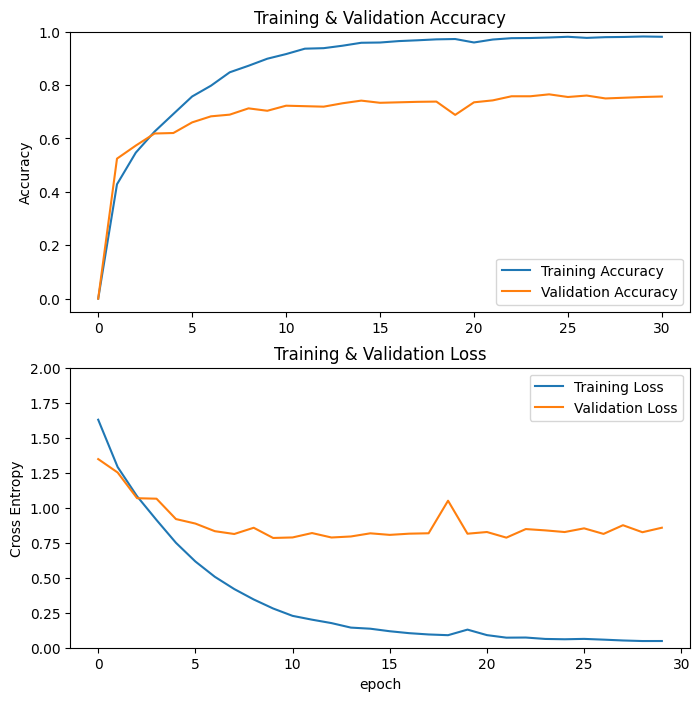

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training & Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training & Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
predictions = np.array([])
test_labels =  np.array([])
#for x, y in test_dataset:
#  predictions = np.concatenate([predictions, project_model.predict_classes(x)])
# test_labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

len(test_dataset)
#tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

53